<a href="https://colab.research.google.com/github/OmerFarukTal/FourierGPT/blob/main/Comp542_Project_Final.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# We always start with a dataset to train on. Let's download the tiny shakespeare dataset
!wget https://raw.githubusercontent.com/karpathy/char-rnn/master/data/tinyshakespeare/input.txt

--2023-06-14 13:20:24--  https://raw.githubusercontent.com/karpathy/char-rnn/master/data/tinyshakespeare/input.txt
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1115394 (1.1M) [text/plain]
Saving to: ‘input.txt’

input.txt           100%[===================>]   1.06M  --.-KB/s    in 0.02s   

2023-06-14 13:20:24 (58.3 MB/s) - ‘input.txt’ saved [1115394/1115394]



In [ ]:
# read it in to inspect it
with open('input.txt', 'r', encoding='utf-8') as f:
    text = f.read()

In [ ]:
print("length of dataset in characters: ", len(text))

length of dataset in characters:  1115394


In [ ]:
# let's look at the first 1000 characters
print(text[:1000])

First Citizen:
Before we proceed any further, hear me speak.

All:
Speak, speak.

First Citizen:
You are all resolved rather to die than to famish?

All:
Resolved. resolved.

First Citizen:
First, you know Caius Marcius is chief enemy to the people.

All:
We know't, we know't.

First Citizen:
Let us kill him, and we'll have corn at our own price.
Is't a verdict?

All:
No more talking on't; let it be done: away, away!

Second Citizen:
One word, good citizens.

First Citizen:
We are accounted poor citizens, the patricians good.
What authority surfeits on would relieve us: if they
would yield us but the superfluity, while it were
wholesome, we might guess they relieved us humanely;
but they think we are too dear: the leanness that
afflicts us, the object of our misery, is as an
inventory to particularise their abundance; our
sufferance is a gain to them Let us revenge this with
our pikes, ere we become rakes: for the gods know I
speak this in hunger for bread, not in thirst for revenge.



In [ ]:
# here are all the unique characters that occur in this text
chars = sorted(list(set(text)))
vocab_size = len(chars)
print(''.join(chars))
print(vocab_size)


 !$&',-.3:;?ABCDEFGHIJKLMNOPQRSTUVWXYZabcdefghijklmnopqrstuvwxyz
65


In [ ]:
# create a mapping from characters to integers
stoi = { ch:i for i,ch in enumerate(chars) }
itos = { i:ch for i,ch in enumerate(chars) }
encode = lambda s: [stoi[c] for c in s] # encoder: take a string, output a list of integers
decode = lambda l: ''.join([itos[i] for i in l]) # decoder: take a list of integers, output a string

print(encode("hii there"))
print(decode(encode("hii there")))

[46, 47, 47, 1, 58, 46, 43, 56, 43]
hii there


In [ ]:
# let's now encode the entire text dataset and store it into a torch.Tensor
import torch # we use PyTorch: https://pytorch.org
data = torch.tensor(encode(text), dtype=torch.long)
print(data.shape, data.dtype)
print(data[:1000]) # the 1000 characters we looked at earier will to the GPT look like this

torch.Size([1115394]) torch.int64
tensor([18, 47, 56, 57, 58,  1, 15, 47, 58, 47, 64, 43, 52, 10,  0, 14, 43, 44,
        53, 56, 43,  1, 61, 43,  1, 54, 56, 53, 41, 43, 43, 42,  1, 39, 52, 63,
         1, 44, 59, 56, 58, 46, 43, 56,  6,  1, 46, 43, 39, 56,  1, 51, 43,  1,
        57, 54, 43, 39, 49,  8,  0,  0, 13, 50, 50, 10,  0, 31, 54, 43, 39, 49,
         6,  1, 57, 54, 43, 39, 49,  8,  0,  0, 18, 47, 56, 57, 58,  1, 15, 47,
        58, 47, 64, 43, 52, 10,  0, 37, 53, 59,  1, 39, 56, 43,  1, 39, 50, 50,
         1, 56, 43, 57, 53, 50, 60, 43, 42,  1, 56, 39, 58, 46, 43, 56,  1, 58,
        53,  1, 42, 47, 43,  1, 58, 46, 39, 52,  1, 58, 53,  1, 44, 39, 51, 47,
        57, 46, 12,  0,  0, 13, 50, 50, 10,  0, 30, 43, 57, 53, 50, 60, 43, 42,
         8,  1, 56, 43, 57, 53, 50, 60, 43, 42,  8,  0,  0, 18, 47, 56, 57, 58,
         1, 15, 47, 58, 47, 64, 43, 52, 10,  0, 18, 47, 56, 57, 58,  6,  1, 63,
        53, 59,  1, 49, 52, 53, 61,  1, 15, 39, 47, 59, 57,  1, 25, 39, 56, 41,
      

In [ ]:
# Let's now split up the data into train and validation sets
n = int(0.9*len(data)) # first 90% will be train, rest val
train_data = data[:n]
val_data = data[n:]

In [ ]:
block_size = 8
train_data[:block_size+1]

tensor([18, 47, 56, 57, 58,  1, 15, 47, 58])

In [ ]:
x = train_data[:block_size]
y = train_data[1:block_size+1]
for t in range(block_size):
    context = x[:t+1]
    target = y[t]
    print(f"when input is {context} the target: {target}")

when input is tensor([18]) the target: 47
when input is tensor([18, 47]) the target: 56
when input is tensor([18, 47, 56]) the target: 57
when input is tensor([18, 47, 56, 57]) the target: 58
when input is tensor([18, 47, 56, 57, 58]) the target: 1
when input is tensor([18, 47, 56, 57, 58,  1]) the target: 15
when input is tensor([18, 47, 56, 57, 58,  1, 15]) the target: 47
when input is tensor([18, 47, 56, 57, 58,  1, 15, 47]) the target: 58


In [ ]:
torch.manual_seed(1337)
batch_size = 4 # how many independent sequences will we process in parallel?
block_size = 8 # what is the maximum context length for predictions?

def get_batch(split):
    # generate a small batch of data of inputs x and targets y
    data = train_data if split == 'train' else val_data
    ix = torch.randint(len(data) - block_size, (batch_size,))
    x = torch.stack([data[i:i+block_size] for i in ix])
    y = torch.stack([data[i+1:i+block_size+1] for i in ix])
    return x, y

xb, yb = get_batch('train')
print('inputs:')
print(xb.shape)
print(xb)
print('targets:')
print(yb.shape)
print(yb)

print('----')

for b in range(batch_size): # batch dimension
    for t in range(block_size): # time dimension
        context = xb[b, :t+1]
        target = yb[b,t]
        print(f"when input is {context.tolist()} the target: {target}")

inputs:
torch.Size([4, 8])
tensor([[24, 43, 58,  5, 57,  1, 46, 43],
        [44, 53, 56,  1, 58, 46, 39, 58],
        [52, 58,  1, 58, 46, 39, 58,  1],
        [25, 17, 27, 10,  0, 21,  1, 54]])
targets:
torch.Size([4, 8])
tensor([[43, 58,  5, 57,  1, 46, 43, 39],
        [53, 56,  1, 58, 46, 39, 58,  1],
        [58,  1, 58, 46, 39, 58,  1, 46],
        [17, 27, 10,  0, 21,  1, 54, 39]])
----
when input is [24] the target: 43
when input is [24, 43] the target: 58
when input is [24, 43, 58] the target: 5
when input is [24, 43, 58, 5] the target: 57
when input is [24, 43, 58, 5, 57] the target: 1
when input is [24, 43, 58, 5, 57, 1] the target: 46
when input is [24, 43, 58, 5, 57, 1, 46] the target: 43
when input is [24, 43, 58, 5, 57, 1, 46, 43] the target: 39
when input is [44] the target: 53
when input is [44, 53] the target: 56
when input is [44, 53, 56] the target: 1
when input is [44, 53, 56, 1] the target: 58
when input is [44, 53, 56, 1, 58] the target: 46
when input is [44, 53

In [ ]:
print(xb) # our input to the transformer

tensor([[24, 43, 58,  5, 57,  1, 46, 43],
        [44, 53, 56,  1, 58, 46, 39, 58],
        [52, 58,  1, 58, 46, 39, 58,  1],
        [25, 17, 27, 10,  0, 21,  1, 54]])


# **MODEL**

In [ ]:
import torch
import torch.nn as nn
from torch.nn import functional as F
torch.manual_seed(1337)

In [ ]:
import torch
import torch.nn as nn
from torch.nn import functional as F

# hyperparameters
batch_size = 16 # how many independent sequences will we process in parallel?
block_size = 32 # what is the maximum context length for predictions?
max_iters = 15000
eval_interval = 100
learning_rate = 1e-3
device = 'cuda' if torch.cuda.is_available() else 'cpu'
eval_iters = 200
n_embd = 64
n_head = 4
n_layer = 4
dropout = 0.1
# ------------

torch.manual_seed(1337)

# wget https://raw.githubusercontent.com/karpathy/char-rnn/master/data/tinyshakespeare/input.txt
with open('input.txt', 'r', encoding='utf-8') as f:
    text = f.read()

# here are all the unique characters that occur in this text
chars = sorted(list(set(text)))
vocab_size = len(chars)
# create a mapping from characters to integers
stoi = { ch:i for i,ch in enumerate(chars) }
itos = { i:ch for i,ch in enumerate(chars) }
encode = lambda s: [stoi[c] for c in s] # encoder: take a string, output a list of integers
decode = lambda l: ''.join([itos[i] for i in l]) # decoder: take a list of integers, output a string

# Train and test splits
data = torch.tensor(encode(text), dtype=torch.long)
n = int(0.9*len(data)) # first 90% will be train, rest val
train_data = data[:n]
val_data = data[n:]

# data loading
def get_batch(split):
    # generate a small batch of data of inputs x and targets y
    data = train_data if split == 'train' else val_data
    ix = torch.randint(len(data) - block_size, (batch_size,))
    x = torch.stack([data[i:i+block_size] for i in ix])
    y = torch.stack([data[i+1:i+block_size+1] for i in ix])
    x, y = x.to(device), y.to(device)
    return x, y

@torch.no_grad()
def estimate_loss(model):
    out = {}
    model.eval()
    for split in ['train', 'val']:
        losses = torch.zeros(eval_iters)
        for k in range(eval_iters):
            X, Y = get_batch(split)
            logits, loss = model(X, Y)
            losses[k] = loss.item()
        out[split] = losses.mean()
    model.train()
    return out


In [ ]:
batch_size = 16 # how many independent sequences will we process in parallel?
block_size = 32 # what is the maximum context length for predictions?
max_iters = 5000
eval_interval = 100
learning_rate = 1e-3
eval_iters = 200
n_embd = 64
n_layer = 4
dropout = 0.1
R_C = 2.71

### Self Attention Model

In [ ]:
class AttentionHead(nn.Module):
    """ one head of self-attention """

    def __init__(self, head_size):
        super().__init__()
        self.key = nn.Linear(n_embd, head_size, bias=False)
        self.query = nn.Linear(n_embd, head_size, bias=False)
        self.value = nn.Linear(n_embd, head_size, bias=False)
        self.register_buffer('tril', torch.tril(torch.ones(block_size, block_size)))

        self.dropout = nn.Dropout(dropout)

    def forward(self, x):
        B,T,C = x.shape
        k = self.key(x)   # (B,T,C)
        q = self.query(x) # (B,T,C)
        # compute attention scores ("affinities")
        wei = q @ k.transpose(-2,-1) * C**-0.5 # (B, T, C) @ (B, C, T) -> (B, T, T)
        wei = wei.masked_fill(self.tril[:T, :T] == 0, float('-inf')) # (B, T, T)
        wei = F.softmax(wei, dim=-1) # (B, T, T)
        wei = self.dropout(wei)
        # perform the weighted aggregation of the values
        v = self.value(x) # (B,T,C)
        out = wei @ v # (B, T, T) @ (B, T, C) -> (B, T, C)
        return out

class MultiHeadAttention(nn.Module):
    """ multiple heads of self-attention in parallel """

    def __init__(self, num_heads, head_size):
        super().__init__()
        self.heads = nn.ModuleList([AttentionHead(head_size) for _ in range(num_heads)])
        self.proj = nn.Linear(n_embd, n_embd)
        self.dropout = nn.Dropout(dropout)

    def forward(self, x):
        out = torch.cat([h(x) for h in self.heads], dim=-1)
        out = self.dropout(self.proj(out))
        return out

class AttentionBlock(nn.Module):
    """ Transformer block: communication followed by computation """

    def __init__(self, n_embd, n_head):
        # n_embd: embedding dimension, n_head: the number of heads we'd like
        super().__init__()
        head_size = n_embd // n_head
        self.sa = MultiHeadAttention(n_head, head_size)
        self.ffwd = FeedFoward()
        self.ln1 = nn.LayerNorm(n_embd)
        self.ln2 = nn.LayerNorm(n_embd)

    def forward(self, x):
        x = x + self.sa(self.ln1(x))
        x = x + self.ffwd(self.ln2(x))
        return x

### Fourier Head Type 1

In [ ]:
class FourierHead1(nn.Module):
  """ one head of the attention """
  def __init__(self):
    super().__init__()


    self.register_buffer('wei', torch.zeros(block_size, 1))
    for i in range(block_size):
      self.wei[i,0] = R_C**(i-block_size+1)

    self.register_buffer('summer', torch.tril(torch.ones(block_size, block_size)))

  def forward(self, x):
    y = torch.fft.fft(x, dim = -1) # in hidden dimension

    T = x.shape[1]
    if T != block_size:

      y = y * self.wei[block_size - T:block_size,:]

      y = self.summer[0:T, 0:T] @ y.real

    else:
      y = y * self.wei ## Open this

      y = self.summer @ y.real
    ## With linear layer(for only real) 4999->2.24 ; With linear layer(for only real) 4999->2.22 ; Without linear layer 4999->2.34

    return y.real

class FourierBlock1(nn.Module):
  def __init__(self):
        # n_embd: embedding dimension, n_head: the number of heads we'd like
        super().__init__()
        self.head = FourierHead1()
        self.FF = FeedFoward()
        self.ln1 = nn.LayerNorm(n_embd)
        self.ln2 = nn.LayerNorm(n_embd)

  def forward(self, x):
      x = x + self.head(self.ln1(x))
      x = x + self.FF(self.ln2(x))
      return x


### Fourier Head Type 2

In [ ]:
class FourierHead2(nn.Module):
  """ one head of the attention """
  def __init__(self):
    super().__init__()


    self.register_buffer('wei', torch.zeros(block_size, 1))
    for i in range(block_size):
      self.wei[i,0] = R_C**(i-block_size+1)

    self.register_buffer('summer', torch.tril(torch.ones(block_size, block_size)))


    self.register_buffer('gatherer', torch.ones(batch_size, block_size, n_embd + block_size - 1, dtype = torch.int64))
    for k in range(batch_size):
      for i in range(block_size):
        for j in range(n_embd + block_size - 1):
          self.gatherer[k][i][j] = (j - i) % (n_embd + block_size - 1)


    #print(self.gatherer)


  def forward(self, x):
    # The input shape will be # B, T, C
    T = x.shape[1]
    B = x.shape[0]

    y = F.pad(x, (0, block_size -1), "constant", 0)

    if B!= batch_size or T!= block_size:
      y = torch.gather(y[:,:T,:], 2,self.gatherer[:1,:T,:])
    else:
      y = torch.gather(y,2, self.gatherer)


    y = torch.fft.fft(y, dim = -1) # in hidden dimension # originally on x

    if T != block_size:

      y = y * self.wei[block_size - T:block_size,:]

      y = self.summer[0:T, 0:T] @ y.real

    else:
      y = y * self.wei ## Open this

      y = self.summer @ y.real
    ## With linear layer(for only real) 4999->2.24 ; With linear layer(for only real) 4999->2.22 ; Without linear layer 4999->2.34

    """
    y = F.softmax(y, dim=-1)
    y = y * x
    """

    """
    Masking on the y is needed
    """

    return y.real

class FourierBlock2(nn.Module):
  def __init__(self):
    super().__init__()


    self.net = nn.Sequential(
        nn.Linear(n_embd + block_size -1, 2*n_embd),
        nn.ReLU(),
        nn.Linear(2 * n_embd, n_embd),
        nn.Dropout(dropout),
    )
    self.ln3 = nn.LayerNorm(n_embd + block_size -1)



    self.head = FourierHead2()
    self.FF = FeedFoward()
    self.ln1 = nn.LayerNorm(n_embd)
    self.ln2 = nn.LayerNorm(n_embd)

  def forward(self, x):

    x = x + self.net(self.head(self.ln1(x)))
    #x = self.head(self.ln1(x))

    #x = self.net(self.ln3(x))

    x = x + self.FF(self.ln2(x))
    return x

## Language Model

In [ ]:
class FeedFoward(nn.Module):
  def __init__(self):
    super().__init__()

    self.net = nn.Sequential(
        nn.Linear(n_embd, 4*n_embd),
        nn.ReLU(),
        nn.Linear(4 * n_embd, n_embd),
        nn.Dropout(dropout),
    )

  def forward(self, x):
    return self.net(x)

class LanguageModel(nn.Module):

    def __init__(self):
        super().__init__()
        # each token directly reads off the logits for the next token from a lookup table
        self.token_embedding_table = nn.Embedding(vocab_size, n_embd)
        self.position_embedding_table = nn.Embedding(block_size, n_embd)

        """ FOURIER """

        self.fourierBlocks = nn.Sequential(*[FourierBlock2() for _ in range(2)]) ### Fourier Block Type


        """ SELF ATTENTION """

        self.attentionBlocks = nn.Sequential(*[AttentionBlock(n_embd, n_head=n_head) for _ in range(2)])


        self.ln_f = nn.LayerNorm(n_embd) # final layer norm
        self.lm_head = nn.Linear(n_embd, vocab_size)

    def forward(self, idx, targets=None):
        B, T = idx.shape

        # idx and targets are both (B,T) tensor of integers
        tok_emb = self.token_embedding_table(idx) # (B,T,C)
        pos_emb = self.position_embedding_table(torch.arange(T, device=device)) # (T,C)
        x = tok_emb + pos_emb # (B,T,C)

        """ SELF ATTENTION """

        x = self.attentionBlocks(x) # (B,T,C)

        """ FOURIER """

        x = self.fourierBlocks(x) # (B,T,C)


        x = self.ln_f(x) # (B,T,C)
        logits = self.lm_head(x) # (B,T,vocab_size)


        if targets is None:
            loss = None
        else:
            B, T, C = logits.shape
            logits = logits.view(B*T, C)
            targets = targets.view(B*T)
            loss = F.cross_entropy(logits, targets)


        return logits, loss

    def generate(self, idx, max_new_tokens):
        # idx is (B, T) array of indices in the current context
        for _ in range(max_new_tokens):
            # crop idx to the last block_size tokens
            idx_cond = idx[:, -block_size:]
            # get the predictions
            logits, loss = self(idx_cond)
            # focus only on the last time step
            logits = logits[:, -1, :] # becomes (B, C)
            # apply softmax to get probabilities
            probs = F.softmax(logits, dim=-1) # (B, C)
            # sample from the distribution
            idx_next = torch.multinomial(probs, num_samples=1) # (B, 1)
            # append sampled index to the running sequence
            idx = torch.cat((idx, idx_next), dim=1) # (B, T+1)
        return idx





model2 = LanguageModel()
m2 = model2.to(device)
# print the number of parameters in the model
print(sum(p.numel() for p in m2.parameters())/1e6, 'M parameters')


# create a PyTorch optimizer
optimizer = torch.optim.AdamW(model2.parameters(), lr=learning_rate)

0.218301 M parameters


In [ ]:
context = torch.zeros((1, 1), dtype=torch.long, device=device)
print(decode(m2.generate(context, max_new_tokens=2000)[0].tolist()))


xP:mhF!ORwa3S-osFk3f?3rdSOEzxOvRM'S&bE; SA-KAd?Siaoanf&MBWBkcn$rSQCqDLkVDPyo.WGKour
IXutCbkgBSKPbLMv;TAw XQ$tNk$n &x:ZPe;q!&xLV-tsj;BODi kVPzx,
GqG!?3v,sZn3;MPjXgS,&qsuOvrQS H&Z$GjxLgn3jXVrjCD j3ny;.ExOeZDVzlu;e;S$;jX;Fq3!A-&SjRFa-wva?xmG$rP3GB;DrS G
qVCttpru-e,.3qGa;FA;rP-ePsuf;';CWBYhDsDs'dxq3K.t.q?3jVwSV,-irODGQD3h,fH$VEKsVC!xbXoA3vKA3Ut3:NehyJ3rvP,3 VcrG$ cENWvrFIKRjSmnqlTw:r:clWS&Rd$ti$qsCZVuCPPqe;Dao.l$,;VjqKTP-XpnPXDmmwLB$zrZIZ;RDHC!VXt;wL?3Q3SDmM&q$Yx&oG$ y
H
!gfFCr?DDQmyUOdi$PIDejS&ut&dmS-ZmM$rX-;o!qSWbvHrsfCDgNFs NPh&'-ngSnayF'qv;yNePu,it:XXPVH.$ XF3WCDCDJXn,NlBXsefPXcdCDMxP'YzX;rFALMrVvZ
iB;HG3nwGgEQSUOyVT3Gtz?e&sV:DNcA,:-Z&Vs.KVO':FxZ cE:mRSquG x,-X3 Zy.ETmnfksPGZS.tCxu&mSVvorv ZUqrmDjNXXDEuc,&33;ivhI!;SrOSfwGZ-qdwMy'ZqADwVPXlVlJM-MIQ;R!;rjZoJZYpOg;po!D
!RSyl.sCYMHEwAqyR?PI-le'3OBojyE3SCMMglR!-EqgQrBWAKBfx&$koysrWMjy:MnzeKMZVcOiQvat$Uu'W?nGqmDOrm?SVQ&$rC,KCfcGDP$HdO$EMM;HIGnHel;$r' GKMnZoxs!pXxuPB3EpUy&L3GfYoXfyT,l$Sr3wXAYoW?;ZWdVys&Y$wYhnek3ac,DPErC&e:Xn-KrmBBGy3fDMcVPXV&

In [ ]:
train_loss_list = []
val_loss_list = []
iter_list = []
for iter in range(max_iters):

    # every once in a while evaluate the loss on train and val sets
    if iter % eval_interval == 0 or iter == max_iters - 1:
        losses = estimate_loss(model2)
        train_loss_list.append(losses["train"])
        val_loss_list.append(losses["val"])
        iter_list.append(max_iters if iter == max_iters-1 else iter)

        print(f"step {iter}: train loss {losses['train']:.4f}, val loss {losses['val']:.4f}")

        if losses['train'] < 1.66:
          break


    # sample a batch of data
    xb, yb = get_batch('train')

    # evaluate the loss
    logits, loss = model2(xb, yb)
    optimizer.zero_grad(set_to_none=True)
    loss.backward()
    optimizer.step()

step 0: train loss 4.4042, val loss 4.3989
step 100: train loss 2.6775, val loss 2.6867
step 200: train loss 2.5268, val loss 2.5261
step 300: train loss 2.4341, val loss 2.4521
step 400: train loss 2.3912, val loss 2.3906
step 500: train loss 2.3226, val loss 2.3286
step 600: train loss 2.2765, val loss 2.2829
step 700: train loss 2.2279, val loss 2.2563
step 800: train loss 2.1981, val loss 2.2293
step 900: train loss 2.1615, val loss 2.1884
step 1000: train loss 2.1292, val loss 2.1728
step 1100: train loss 2.1097, val loss 2.1463
step 1200: train loss 2.0783, val loss 2.1227
step 1300: train loss 2.0632, val loss 2.1084
step 1400: train loss 2.0403, val loss 2.1018
step 1500: train loss 2.0286, val loss 2.0935
step 1600: train loss 2.0056, val loss 2.0660
step 1700: train loss 1.9921, val loss 2.0498
step 1800: train loss 1.9693, val loss 2.0388
step 1900: train loss 1.9553, val loss 2.0359
step 2000: train loss 1.9476, val loss 2.0224
step 2100: train loss 1.9288, val loss 2.0012


In [ ]:
# generate from the model
context = torch.zeros((1, 1), dtype=torch.long, device=device)
print(decode(m2.generate(context, max_new_tokens=2000)[0].tolist()))

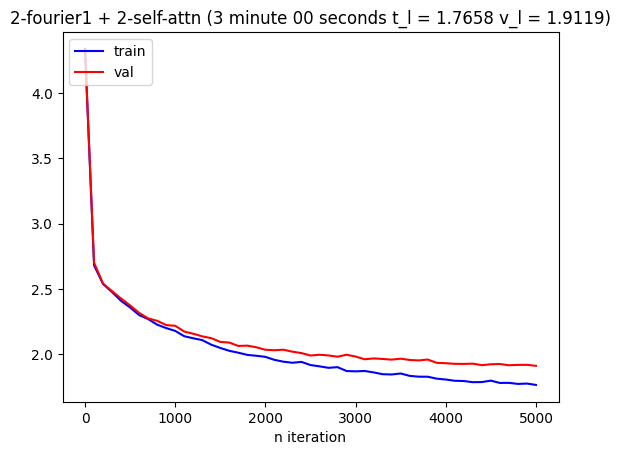

In [ ]:
import matplotlib.pyplot as plt
title = "2-fourier1 + 2-self-attn (3 minute 00 seconds t_l = 1.7658 v_l = 1.9119)"

plt.plot(iter_list, train_loss_list, '-b', label='train')
plt.plot(iter_list, val_loss_list, '-r', label='val')

plt.xlabel("n iteration")
plt.legend(loc='upper left')
plt.title(title)

# save image
plt.savefig(title+".png")  # should before show method

# show
plt.show()

# Pretrain on Corpus

In [ ]:
!pip install transformers

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.2/7.2 MB 79.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 236.8/236.8 kB 20.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 118.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 84.1 MB/s eta 0:00:00


In [ ]:
!pip install datasets

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 485.6/485.6 kB 18.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 110.5/110.5 kB 13.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 212.5/212.5 kB 19.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.3/134.3 kB 16.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 60.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 114.5/114.5 kB 15.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 268.8/268.8 kB 32.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 149.6/149.6 kB 15.4 MB/s eta 0:00:00


In [ ]:
from transformers import TextDataset, DataCollatorForLanguageModeling
import datasets

In [ ]:
dataset = datasets.load_dataset("roneneldan/TinyStories")

Extracting data files:   0%|          | 0/2 [00:00<?, ?it/s]

Generating train split: 0 examples [00:00, ? examples/s]

Generating validation split: 0 examples [00:00, ? examples/s]

Dataset text downloaded and prepared to /root/.cache/huggingface/datasets/roneneldan___text/roneneldan--TinyStories-addf27cb3e610c69/0.0.0/cb1e9bd71a82ad27976be3b12b407850fe2837d80c22c5e03a28949843a8ace2. Subsequent calls will reuse this data.


  0%|          | 0/2 [00:00<?, ?it/s]

In [ ]:
print(type(dataset))
dataset.column_names

<class 'datasets.dataset_dict.DatasetDict'>


{'train': ['text'], 'validation': ['text']}

In [ ]:
dataset["train"][:10]

{'text': ['One day, a little girl named Lily found a needle in her room. She knew it was difficult to play with it because it was sharp. Lily wanted to share the needle with her mom, so she could sew a button on her shirt.',
  'Lily went to her mom and said, "Mom, I found this needle. Can you share it with me and sew my shirt?" Her mom smiled and said, "Yes, Lily, we can share the needle and fix your shirt."',
  "Together, they shared the needle and sewed the button on Lily's shirt. It was not difficult for them because they were sharing and helping each other. After they finished, Lily thanked her mom for sharing the needle and fixing her shirt. They both felt happy because they had shared and worked together.",
  '<|endoftext|>',
  'Once upon a time, there was a little car named Beep. Beep loved to go fast and play in the sun. Beep was a healthy car because he always had good fuel. Good fuel made Beep happy and strong.',
  'One day, Beep was driving in the park when he saw a big tree

In [ ]:
from transformers import GPT2Tokenizer

tokenizer = GPT2Tokenizer.from_pretrained("gpt2")

def tokenize_text(text):
    # Tokenize the text using the GPT2 tokenizer
    tokenized_text = tokenizer.encode(text)

    return tokenized_text






In [ ]:
dataset["train"][:10]["text"]

['One day, a little girl named Lily found a needle in her room. She knew it was difficult to play with it because it was sharp. Lily wanted to share the needle with her mom, so she could sew a button on her shirt.',
 'Lily went to her mom and said, "Mom, I found this needle. Can you share it with me and sew my shirt?" Her mom smiled and said, "Yes, Lily, we can share the needle and fix your shirt."',
 "Together, they shared the needle and sewed the button on Lily's shirt. It was not difficult for them because they were sharing and helping each other. After they finished, Lily thanked her mom for sharing the needle and fixing her shirt. They both felt happy because they had shared and worked together.",
 '<|endoftext|>',
 'Once upon a time, there was a little car named Beep. Beep loved to go fast and play in the sun. Beep was a healthy car because he always had good fuel. Good fuel made Beep happy and strong.',
 'One day, Beep was driving in the park when he saw a big tree. The tree had

In [ ]:
import torch
import torch.nn as nn
from torch.nn import functional as F
device = 'cuda' if torch.cuda.is_available() else 'cpu'
torch.manual_seed(1337)
batch_size = 4 # how many independent sequences will we process in parallel?
block_size = 8 # what is the maximum context length for predictions?

In [ ]:
def get_random_text(split):
  ix = torch.randint(len(dataset[split]) - int(1.5 * block_size), (batch_size,))
  random_sents = []
  for i in ix:
    random_sents.append(" ".join(dataset[split][i:i + block_size]["text"]))

  return random_sents

a = get_random_text("validation")
print(len(a))
print(len(a[0]))
print(a[0])

def prepare_a_batch():
  random_batch_of_text = get_random_text("train")

  input_batch = []
  output_batch = []
  for i in range(len(random_batch_of_text)):
    tokenized = tokenize_text(random_batch_of_text[i])
    ix = torch.randint(len(tokenized) - block_size -2, (1,))
    x = tokenized[ix: ix+block_size]
    y = tokenized[ix+1: ix+block_size+1]
    input_batch.append(x)
    output_batch.append(y)


  input_batch = torch.tensor(input_batch)
  output_batch = torch.tensor(output_batch)

  input_batch = input_batch.to(device)
  output_batch = output_batch.to(device)

  return input_batch, output_batch



4
1793
Mia was curious. She had never played with dough before. She followed grandma to the kitchen and saw a big bowl of white dough. Grandma gave her some dough and showed her how to roll it and shape it. Mia felt the dough in her hands. It was soft and sticky and warm. It was different from clay, but it was also fun. She started to make something with the dough. She made a round ball for the head, a long snake for the body, four small balls for the legs, and two ears. She made a dog with the dough. She showed her dog to grandma, who smiled and praised her. She said Mia was very clever and creative. She said she liked her dog very much. She said she would bake the dog in the oven and then Mia could paint it and keep it. Mia felt happy. She still missed her clay, but she also liked her dough dog. She hugged grandma and thanked her. She decided to make more things with the dough. She made a cat, a bird, a flower, and a house. She had fun with the dough. She did not feel frustrated anym

In [ ]:
torch.manual_seed(1337)
#batch_size = 4 # how many independent sequences will we process in parallel?
#block_size = 8 # what is the maximum context length for predictions?

def get_batch(split):
    # generate a small batch of data of inputs x and targets y
    random_batch_of_text = get_random_text(split)

    input_batch = []
    output_batch = []
    for i in range(len(random_batch_of_text)):
      tokenized = tokenize_text(random_batch_of_text[i])

      if len(tokenized) - block_size -2 <= 0:
        print(len(tokenized) - block_size -2)
        print(random_batch_of_text[i])
        print(len(tokenized) , block_size)
        print(tokenized)

      ix = torch.randint(len(tokenized) - block_size -2, (1,))
      x = tokenized[ix: ix+block_size]
      y = tokenized[ix+1: ix+block_size+1]
      input_batch.append(x)
      output_batch.append(y)


    input_batch = torch.tensor(input_batch)
    output_batch = torch.tensor(output_batch)

    input_batch = input_batch.to(device)
    output_batch = output_batch.to(device)

    return input_batch, output_batch


x, y = get_batch("validation")
print(x)
print(x.shape)

"""
@torch.no_grad()
def estimate_loss(model):
    out = {"train" : 0}
    model.eval()
    losses = torch.zeros(eval_iters)
    for k in range(eval_iters):
        X, Y = get_batch()
        logits, loss = model(X, Y)
        losses[k] = loss.item()
    out["train"] = losses.mean()
    model.train()
    return out
"""
@torch.no_grad()
def estimate_loss(model):
    out = {}
    model.eval()
    for split in ['train', 'validation']:
        losses = torch.zeros(eval_iters)
        for k in range(eval_iters):
            X, Y = get_batch(split)
            logits, loss = model(X, Y)
            losses[k] = loss.item()
        out[split] = losses.mean()
    model.train()
    return out

tensor([[   13,  1375,   531,   673,   561, 28450,   262,  3290],
        [  286, 18432,    13,   383,  5863,   613,    65,   903],
        [  373,   257, 10787,  3797,  3706,   854,  1984,   364],
        [  290,   262,  3797,    13,  1119,   547,   523,  3772]],
       device='cuda:0')
torch.Size([4, 8])


In [ ]:
batch_size = 16 # how many independent sequences will we process in parallel?
block_size = 64 # what is the maximum context length for predictions?
max_iters = 10000
eval_interval = 100
learning_rate = 1e-3
eval_iters = 200
n_embd = 256
n_layer = 4
dropout = 0.1
R_C = 2.71
vocab_size = 50257
n_head = 4

In [ ]:
class AttentionHead(nn.Module):
    """ one head of self-attention """

    def __init__(self, head_size):
        super().__init__()
        self.key = nn.Linear(n_embd, head_size, bias=False)
        self.query = nn.Linear(n_embd, head_size, bias=False)
        self.value = nn.Linear(n_embd, head_size, bias=False)
        self.register_buffer('tril', torch.tril(torch.ones(block_size, block_size)))

        self.dropout = nn.Dropout(dropout)

    def forward(self, x):
        B,T,C = x.shape
        k = self.key(x)   # (B,T,C)
        q = self.query(x) # (B,T,C)
        # compute attention scores ("affinities")
        wei = q @ k.transpose(-2,-1) * C**-0.5 # (B, T, C) @ (B, C, T) -> (B, T, T)
        wei = wei.masked_fill(self.tril[:T, :T] == 0, float('-inf')) # (B, T, T)
        wei = F.softmax(wei, dim=-1) # (B, T, T)
        wei = self.dropout(wei)
        # perform the weighted aggregation of the values
        v = self.value(x) # (B,T,C)
        out = wei @ v # (B, T, T) @ (B, T, C) -> (B, T, C)
        return out

class MultiHeadAttention(nn.Module):
    """ multiple heads of self-attention in parallel """

    def __init__(self, num_heads, head_size):
        super().__init__()
        self.heads = nn.ModuleList([AttentionHead(head_size) for _ in range(num_heads)])
        self.proj = nn.Linear(n_embd, n_embd)
        self.dropout = nn.Dropout(dropout)

    def forward(self, x):
        out = torch.cat([h(x) for h in self.heads], dim=-1)
        out = self.dropout(self.proj(out))
        return out

class AttentionBlock(nn.Module):
    """ Transformer block: communication followed by computation """

    def __init__(self, n_embd, n_head):
        # n_embd: embedding dimension, n_head: the number of heads we'd like
        super().__init__()
        head_size = n_embd // n_head
        self.sa = MultiHeadAttention(n_head, head_size)
        self.ffwd = FeedFoward()
        self.ln1 = nn.LayerNorm(n_embd)
        self.ln2 = nn.LayerNorm(n_embd)

    def forward(self, x):
        x = x + self.sa(self.ln1(x))
        x = x + self.ffwd(self.ln2(x))
        return x

In [ ]:
#LIGHT HEAD
class FourierHead1(nn.Module):
  """ one head of the attention """
  def __init__(self):
    super().__init__()


    self.register_buffer('wei', torch.zeros(block_size, 1))
    for i in range(block_size):
      self.wei[i,0] = R_C**(i-block_size+1)

    self.register_buffer('summer', torch.tril(torch.ones(block_size, block_size)))

  def forward(self, x):
    y = torch.fft.fft(x, dim = -1) # in hidden dimension

    T = x.shape[1]
    if T != block_size:

      y = y * self.wei[block_size - T:block_size,:]

      y = self.summer[0:T, 0:T] @ y.real

    else:
      y = y * self.wei ## Open this

      y = self.summer @ y.real
    ## With linear layer(for only real) 4999->2.24 ; With linear layer(for only real) 4999->2.22 ; Without linear layer 4999->2.34

    return y.real

class FourierBlock1(nn.Module):
  def __init__(self):
        # n_embd: embedding dimension, n_head: the number of heads we'd like
        super().__init__()
        self.head = FourierHead1()
        self.FF = FeedFoward()
        self.ln1 = nn.LayerNorm(n_embd)
        self.ln2 = nn.LayerNorm(n_embd)

  def forward(self, x):
      x = x + self.head(self.ln1(x))
      x = x + self.FF(self.ln2(x))
      return x


In [ ]:
#HEAVY HEAD
class FourierHead2(nn.Module):
  """ one head of the attention """
  def __init__(self):
    super().__init__()


    self.register_buffer('wei', torch.zeros(block_size, 1))
    for i in range(block_size):
      self.wei[i,0] = R_C**(i-block_size+1)

    self.register_buffer('summer', torch.tril(torch.ones(block_size, block_size)))


    self.register_buffer('gatherer', torch.ones(batch_size, block_size, n_embd + block_size - 1, dtype = torch.int64))
    for k in range(batch_size):
      for i in range(block_size):
        for j in range(n_embd + block_size - 1):
          self.gatherer[k][i][j] = (j - i) % (n_embd + block_size - 1)


    #print(self.gatherer)


  def forward(self, x):
    # The input shape will be # B, T, C
    T = x.shape[1]
    B = x.shape[0]

    y = F.pad(x, (0, block_size -1), "constant", 0)

    if B!= batch_size or T!= block_size:
      y = torch.gather(y[:,:T,:], 2,self.gatherer[:1,:T,:])
    else:
      y = torch.gather(y,2, self.gatherer)


    y = torch.fft.fft(y, dim = -1) # in hidden dimension # originally on x

    if T != block_size:

      y = y * self.wei[block_size - T:block_size,:]

      y = self.summer[0:T, 0:T] @ y.real

    else:
      y = y * self.wei ## Open this

      y = self.summer @ y.real
    ## With linear layer(for only real) 4999->2.24 ; With linear layer(for only real) 4999->2.22 ; Without linear layer 4999->2.34

    """
    y = F.softmax(y, dim=-1)
    y = y * x
    """

    """
    Masking on the y is needed
    """

    return y.real

class FourierBlock2(nn.Module):
  def __init__(self):
    super().__init__()


    self.net = nn.Sequential(
        nn.Linear(n_embd + block_size -1, 2*n_embd),
        nn.ReLU(),
        nn.Linear(2 * n_embd, n_embd),
        nn.Dropout(dropout),
    )
    self.ln3 = nn.LayerNorm(n_embd + block_size -1)



    self.head = FourierHead2()
    self.FF = FeedFoward()
    self.ln1 = nn.LayerNorm(n_embd)
    self.ln2 = nn.LayerNorm(n_embd)

  def forward(self, x):

    x = x + self.net(self.head(self.ln1(x)))
    #x = self.head(self.ln1(x))

    #x = self.net(self.ln3(x))

    x = x + self.FF(self.ln2(x))
    return x

In [ ]:
class FeedFoward(nn.Module):
  def __init__(self):
    super().__init__()

    self.net = nn.Sequential(
        nn.Linear(n_embd, 4*n_embd),
        nn.ReLU(),
        nn.Linear(4 * n_embd, n_embd),
        nn.Dropout(dropout),
    )

  def forward(self, x):
    return self.net(x)

class LanguageModel(nn.Module):

    def __init__(self):
        super().__init__()
        # each token directly reads off the logits for the next token from a lookup table
        self.token_embedding_table = nn.Embedding(vocab_size, n_embd)
        self.position_embedding_table = nn.Embedding(block_size, n_embd)

        """ FOURIER """


        self.fourierBlocks = nn.Sequential(*[FourierBlock2() for _ in range(4)]) ### Fourier Block Type


        """ SELF ATTENTION """
        """
        self.attentionBlocks = nn.Sequential(*[AttentionBlock(n_embd, n_head=n_head) for _ in range(2)])
        """

        self.ln_f = nn.LayerNorm(n_embd) # final layer norm
        self.lm_head = nn.Linear(n_embd, vocab_size)

    def forward(self, idx, targets=None):
        B, T = idx.shape

        # idx and targets are both (B,T) tensor of integers
        tok_emb = self.token_embedding_table(idx) # (B,T,C)
        pos_emb = self.position_embedding_table(torch.arange(T, device=device)) # (T,C)
        x = tok_emb + pos_emb # (B,T,C)

        """ SELF ATTENTION """
        """
        x = self.attentionBlocks(x) # (B,T,C)
        """
        """ FOURIER """


        x = self.fourierBlocks(x) # (B,T,C)


        x = self.ln_f(x) # (B,T,C)
        logits = self.lm_head(x) # (B,T,vocab_size)


        if targets is None:
            loss = None
        else:
            B, T, C = logits.shape
            logits = logits.view(B*T, C)
            targets = targets.view(B*T)
            loss = F.cross_entropy(logits, targets)


        return logits, loss

    def generate(self, idx, max_new_tokens):
        # idx is (B, T) array of indices in the current context
        for _ in range(max_new_tokens):
            # crop idx to the last block_size tokens
            idx_cond = idx[:, -block_size:]
            # get the predictions
            logits, loss = self(idx_cond)
            # focus only on the last time step
            logits = logits[:, -1, :] # becomes (B, C)
            # apply softmax to get probabilities
            probs = F.softmax(logits, dim=-1) # (B, C)
            # sample from the distribution
            idx_next = torch.multinomial(probs, num_samples=1) # (B, 1)
            # append sampled index to the running sequence
            idx = torch.cat((idx, idx_next), dim=1) # (B, T+1)
        return idx





model2 = LanguageModel()
m2 = model2.to(device)
# print the number of parameters in the model
print(sum(p.numel() for p in m2.parameters())/1e6, 'M parameters')


# create a PyTorch optimizer
optimizer = torch.optim.AdamW(model2.parameters(), lr=learning_rate)

29.088329 M parameters


In [ ]:

context = torch.zeros((1, 1), dtype=torch.long, device=device) + 13
generated = m2.generate(context, max_new_tokens=2000)[0].tolist()

print(generated)

decoded_text = []
for ids in range(len(generated)):
    text = tokenizer.decode(generated[ids])
    decoded_text.append(text)

print(" ".join(decoded_text))


train_loss_list = []
val_loss_list = []
iter_list = []

for iter in range(max_iters):

    # every once in a while evaluate the loss on train and val sets
    if iter % eval_interval == 0 or iter == max_iters - 1:
        losses = estimate_loss(model2)
        print(f"step {iter}: train loss {losses['train']:.4f}, val loss {losses['validation']:.4f}")
        train_loss_list.append(losses["train"])
        val_loss_list.append(losses["validation"])
        iter_list.append(max_iters if iter == max_iters-1 else iter)
        if losses['train'] < 1.66:
          break


    # sample a batch of data
    xb, yb = get_batch("train")

    # evaluate the loss
    logits, loss = model2(xb, yb)
    optimizer.zero_grad(set_to_none=True)
    loss.backward()
    optimizer.step()

# generate from the model
context = torch.zeros((1, 1), dtype=torch.long, device=device) + 13
generated = m2.generate(context, max_new_tokens=2000)[0].tolist()

print(generated)

decoded_text = []
for ids in range(len(generated)):
    text = tokenizer.decode(generated[ids])
    decoded_text.append(text)

print(" ".join(decoded_text))

[13, 11906, 50186, 5080, 49640, 15794, 22262, 40778, 11810, 37845, 48612, 40137, 39536, 37727, 35634, 43438, 13530, 16584, 44858, 12830, 17826, 6063, 34010, 34292, 26214, 46782, 11555, 47580, 28506, 23330, 47764, 44685, 29456, 10827, 7703, 32517, 8679, 41158, 21113, 36187, 21161, 42657, 24774, 42296, 39242, 1958, 24790, 28706, 37786, 39118, 33127, 50227, 46579, 20412, 28982, 18075, 15136, 32868, 35940, 17225, 30190, 5920, 45468, 5389, 12938, 5294, 13724, 19562, 10235, 18265, 46002, 17325, 32456, 9251, 6740, 18321, 3004, 19352, 33755, 15522, 28738, 16233, 49003, 33222, 7902, 49457, 30705, 37236, 24715, 38789, 21663, 40757, 21636, 37300, 30881, 2922, 14455, 7285, 48328, 46146, 31569, 42218, 42700, 17892, 44410, 44739, 31037, 15900, 38650, 29531, 16265, 35029, 10470, 48870, 41888, 37429, 31032, 39784, 15139, 32134, 2807, 10216, 46324, 36089, 4836, 9744, 4697, 10787, 3362, 29918, 9892, 12911, 30838, 2211, 12869, 24570, 26220, 30783, 29911, 40837, 38661, 62, 50219, 19650, 12147, 11799, 3077

In [ ]:
context = torch.zeros((1, 1), dtype=torch.long, device=device) + 13
generated = m2.generate(context, max_new_tokens=2000)[0].tolist()

print(generated)

decoded_text = []
for ids in range(len(generated)):
    text = tokenizer.decode(generated[ids])
    decoded_text.append(text)

generated_text = " ".join(decoded_text)
print(generated_text)
with open("Fourier2_pure.txt", "w") as f:
  f.write(generated_text)

[13, 1180, 5045, 340, 257, 607, 13, 319, 20263, 4252, 2835, 7331, 39072, 1468, 274, 1111, 5436, 13364, 511, 366, 2826, 661, 4186, 26089, 428, 2245, 4252, 527, 373, 547, 465, 373, 8036, 19919, 925, 1422, 1757, 366, 640, 14782, 640, 7122, 1355, 1290, 329, 757, 355, 13, 502, 262, 465, 5811, 13, 1239, 6568, 857, 815, 27884, 2354, 12187, 41643, 1359, 14343, 290, 10357, 1566, 1755, 11, 28515, 28515, 13, 887, 3932, 14464, 465, 1995, 4255, 13, 1881, 1110, 11, 5045, 5615, 287, 262, 5509, 13, 6654, 319, 465, 26394, 1839, 470, 262, 1323, 290, 2067, 284, 3197, 13, 220, 50256, 220, 22772, 373, 523, 6613, 286, 262, 1263, 3881, 13, 1119, 1234, 326, 2712, 757, 13, 4186, 531, 11, 366, 5297, 11, 475, 673, 5784, 1015, 683, 13, 1119, 550, 284, 3745, 502, 651, 617, 12498, 2641, 290, 1392, 14720, 290, 925, 257, 1402, 5933, 11, 290, 331, 13513, 11, 1995, 531, 13, 366, 6090, 314, 765, 284, 1011, 534, 3348, 290, 4966, 706, 607, 1995, 284, 711, 8097, 290, 2497, 2506, 13, 1119, 3114, 845, 7606, 290, 550, 3750, 1

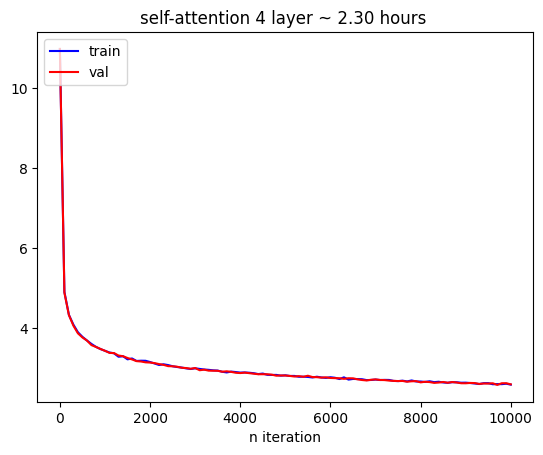

In [ ]:
import matplotlib.pyplot as plt
title = "self-attention 4 layer ~ 2.30 hours "

plt.plot(iter_list, train_loss_list, '-b', label='train')
plt.plot(iter_list, val_loss_list, '-r', label='val')

plt.xlabel("n iteration")
plt.legend(loc='upper left')
plt.title(title)

# save image
plt.savefig(title+".png")  # should before show method

# show
plt.show()

In [ ]:
def calculate_perplexity(model):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model = model.to(device)
    model.eval()

    total_loss = 0
    total_tokens = 0

    with torch.no_grad():
        for i in range(1000):
            batch, y_s = get_batch("validation")

            logits, loss = model(batch, y_s)
            total_loss += loss.item()

            total_tokens += batch.numel()

    average_loss = total_loss / total_tokens
    perplexity = 2**average_loss

    return perplexity


In [ ]:
calculate_perplexity(m2)

1.0025354385499152